In [68]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

from numpy.lib.stride_tricks import as_strided

def conv2d(a, b):
  Hout = a.shape[1] - b.shape[2] + 1
  Wout = a.shape[2] - b.shape[3] + 1

  print(a.shape, a.strides, a.strides[:3] + a.strides[1:])
  a = as_strided(a, (a.shape[0], Hout, Wout, b.shape[2], b.shape[3], a.shape[3]), a.strides[:3] + a.strides[1:])
  print(a.shape, a.strides)
  
  return np.einsum('abcijk,dkij', a, b)

a = np.random.rand(8,200,200,3)
b = np.random.rand(6,3,5,5)
print(a.shape, a.dtype)

c = conv2d(a, b)
c.shape

(8, 200, 200, 3) float64
(8, 200, 200, 3) (960000, 4800, 24, 8) (960000, 4800, 24, 4800, 24, 8)
(8, 196, 196, 5, 5, 3) (960000, 4800, 24, 4800, 24, 8)


(8, 196, 196, 6)

(1, 12, 404, 404) float32
AAA (1, 400, 400, 24)


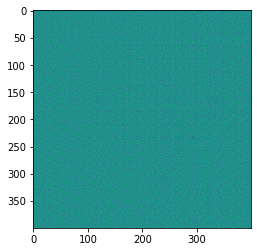

In [97]:
import numpy as np

from numpy.lib.stride_tricks import as_strided

def conv2d(a, b):
  Hout = a.shape[2] - b.shape[2] + 1
  Wout = a.shape[3] - b.shape[3] + 1

  a = as_strided(a, (a.shape[0], a.shape[1], Hout, Wout, b.shape[2], b.shape[3]), a.strides[:] + a.strides[2:])
  
  return np.einsum('akbcij,dkij', a, b)

print(base.shape, base.dtype)
c = np.tanh(conv2d(base, ker))
print("AAA",c.shape)
coeffs = net.coeffs(input).detach().numpy().reshape(24,-1)
res = np.einsum('ik,kj->ji', c.reshape(400*400,24), coeffs).reshape(-1,400,400)

res.shape
plt.imshow(res[0,:,:])

In [15]:
import torch 
import torch.nn as nn

device = torch.device("cpu")

class AE(nn.Module):
    def __init__(self, n_comps, n_coeffs):
        super(AE, self).__init__()
        self.n_coeffs = n_coeffs
        self.n_comps = n_comps
        self.D = nn.Linear(1, self.n_comps*404*404, bias=False)
        self.conv1 = nn.Conv2d(self.n_comps, 2*self.n_comps, kernel_size=5, bias=False)
        self.coeffs = nn.Linear(1, 2*self.n_comps*self.n_coeffs, bias=False)
        
    def forward(self, x):
        base = self.D(x)
        conv1 =  torch.tanh(self.conv1(base.reshape(1, self.n_comps, 404, 404)))   
        coeffs = self.coeffs(x).view(2*self.n_comps, self.n_coeffs)
        return torch.einsum('ik,kj->ji', conv1.view(400*400, 2*self.n_comps), coeffs)
    
net = torch.load("05_05_net.pt", map_location='cpu')
net.eval()
input = torch.ones(1, device=device)
stack = net(input).cpu().detach().numpy().reshape(-1,400,400)

stack.shape

(462, 400, 400)

In [48]:
base = net.D.weight.detach().numpy().reshape(1,12,404,404)
base.shape

(1, 12, 404, 404)

In [49]:
ker = net.conv1.weight.detach().numpy()
ker.shape

(24, 12, 5, 5)

torch.Size([1, 24, 400, 400])


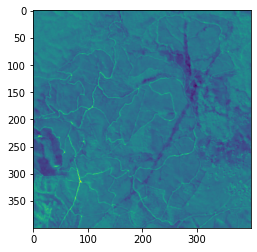

In [98]:
conv1 = torch.tanh(net.conv1(net.D(input).reshape(1, 12, 404, 404)))#.detach().numpy()
print(conv1.shape)
coeffs = net.coeffs(input).view(2*net.n_comps, net.n_coeffs)
result = torch.einsum('ik,kj->ji', conv1.view(400*400, 2*net.n_comps), coeffs)

result = result.detach().numpy().reshape(-1,400,400)
plt.imshow(result[2,:,:])

#0.0025242488, 0.030429404
#0.0025242434, 0.030420015

In [35]:
a = np.random.rand(1,8,2,3)
a.shape, a.strides

((1, 8, 2, 3), (384, 48, 24, 8))

In [36]:
n = 1000
a = np.arange(n)

b = np.lib.stride_tricks.as_strided(a, (n, n), (0, 8))
b

array([[  0,   1,   2, ..., 997, 998, 999],
       [  0,   1,   2, ..., 997, 998, 999],
       [  0,   1,   2, ..., 997, 998, 999],
       ...,
       [  0,   1,   2, ..., 997, 998, 999],
       [  0,   1,   2, ..., 997, 998, 999],
       [  0,   1,   2, ..., 997, 998, 999]])